In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBRegressor
import lightgbm
import catboost
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing, metrics, svm, tree, ensemble, neighbors, linear_model, model_selection,cluster
# sns.set_style("dark-grid")
sns.set_theme(style="darkgrid")
palette_name = 'gist_heat'

In [3]:
df=pd.read_excel('https://github.com/ThePiranhaGuy/fan_predictions/blob/main/Train_data.xlsx?raw=true')
df.columns=[col.lower().replace(" ","_") if type(col) == str else col.strftime('%b-%Y')  for col in df.columns ]
df.warehouse_id=df.warehouse_id+"-"+df.region
# df.drop(columns=['region'],inplace=True)

In [4]:
pd.DataFrame(df.groupby(['warehouse_id']).count()).iloc[:,1]

warehouse_id
Wh-1-NORTH    233
Wh-2-EAST     212
Wh-3-WEST     308
Wh-4-SOUTH    286
Name: sku_id, dtype: int64

Text(0.5, 1.0, 'No of Products in each warehouse/region')

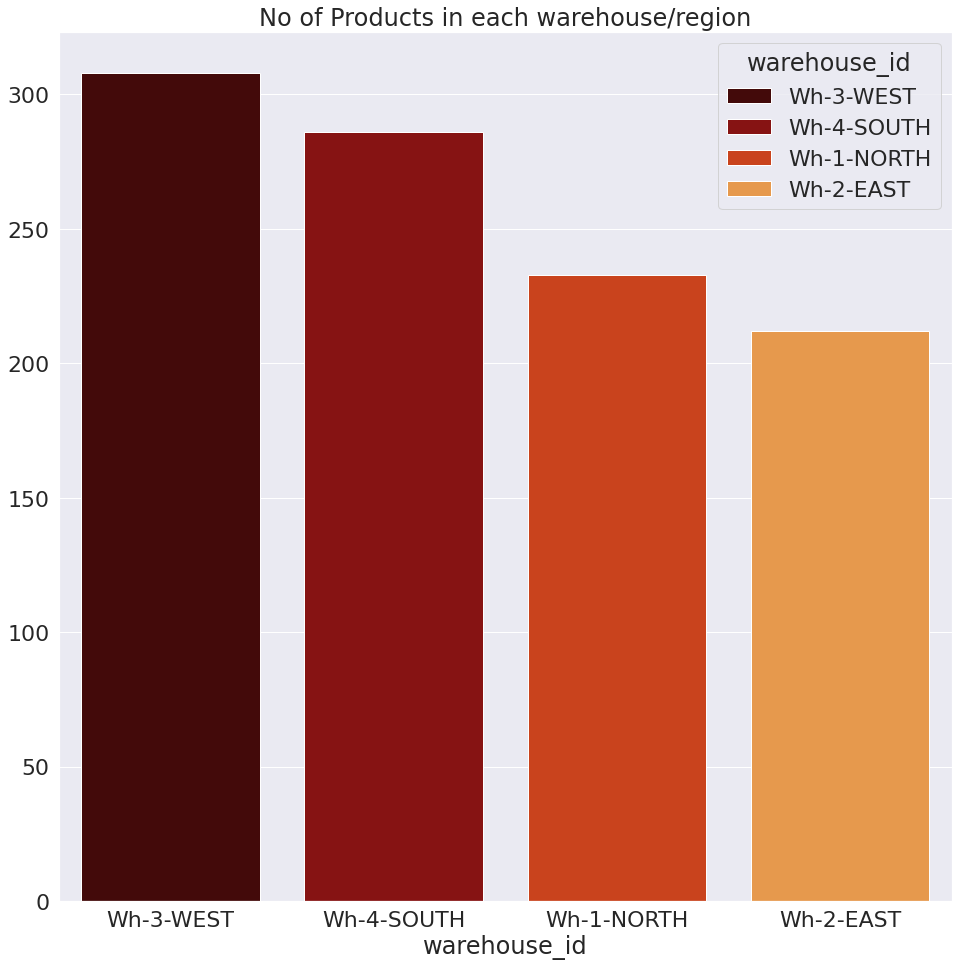

In [5]:
sns.set(font_scale=2)
plt.figure(figsize=(16,16))
counts = pd.DataFrame(df.groupby(['warehouse_id']).count()).iloc[:,1].sort_values(ascending=False)
sns.barplot(x=counts.index,y=counts.values,palette=palette_name,hue=counts.index,dodge=False)
plt.title("No of Products in each warehouse/region")
# plt.rc('ytick',labelsize = 10)
# plt.rc('axes',labelsize = 10)
# plt.legend(y=counts.values)
# _=plt.xticks(rotation="0")

In [6]:
time_data=df.T.iloc[2:]
time_data.columns=time_data.iloc[0,:].tolist()
time_data=time_data.iloc[1:,:].astype(int)
time_data.index=pd.to_datetime(time_data.index)

In [7]:
df.iloc[:,3:]

,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,...,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020,Jan-2021,Feb-2021,Mar-2021,Apr-2021,May-2021
0,27,13,30,14,22,8,8,8,8,8,...,12,8,8,8,8,8,14,16,8,12
1,88,28,127,130,58,10,7,7,7,13,...,16,7,7,7,7,7,13,43,13,43
2,6,6,6,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,162,184,110,172,90,40,18,26,18,66,...,82,78,38,18,22,28,36,352,58,18
4,171,402,627,615,300,417,141,42,72,33,...,468,216,75,6,30,66,141,699,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,7,7,7,7,7,7,7,7,7,7,...,591,167,455,215,135,239,295,7,7,135
1035,49,25,41,13,21,53,33,21,67,21,...,9,9,21,133,9,33,9,103,49,9
1036,21,13,13,21,29,21,21,29,13,13,...,13,13,13,13,13,21,13,13,13,13
1037,15,13,13,11,9,11,36,15,21,15,...,9,9,17,13,11,36,21,17,9,9


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text major ticklabel objects>)

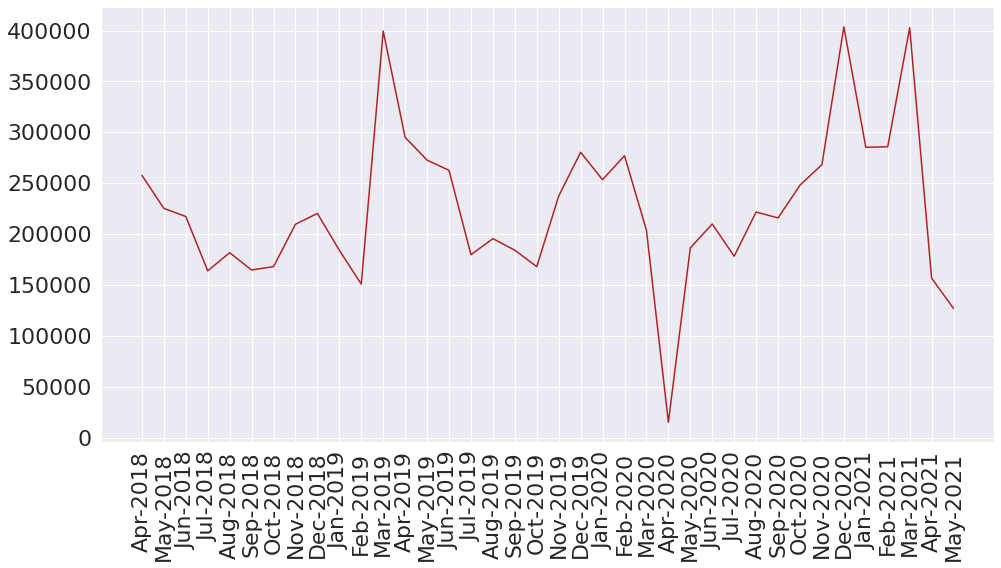

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df.iloc[:,3:].sum(), color = 'firebrick')
plt.xticks(rotation='90')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

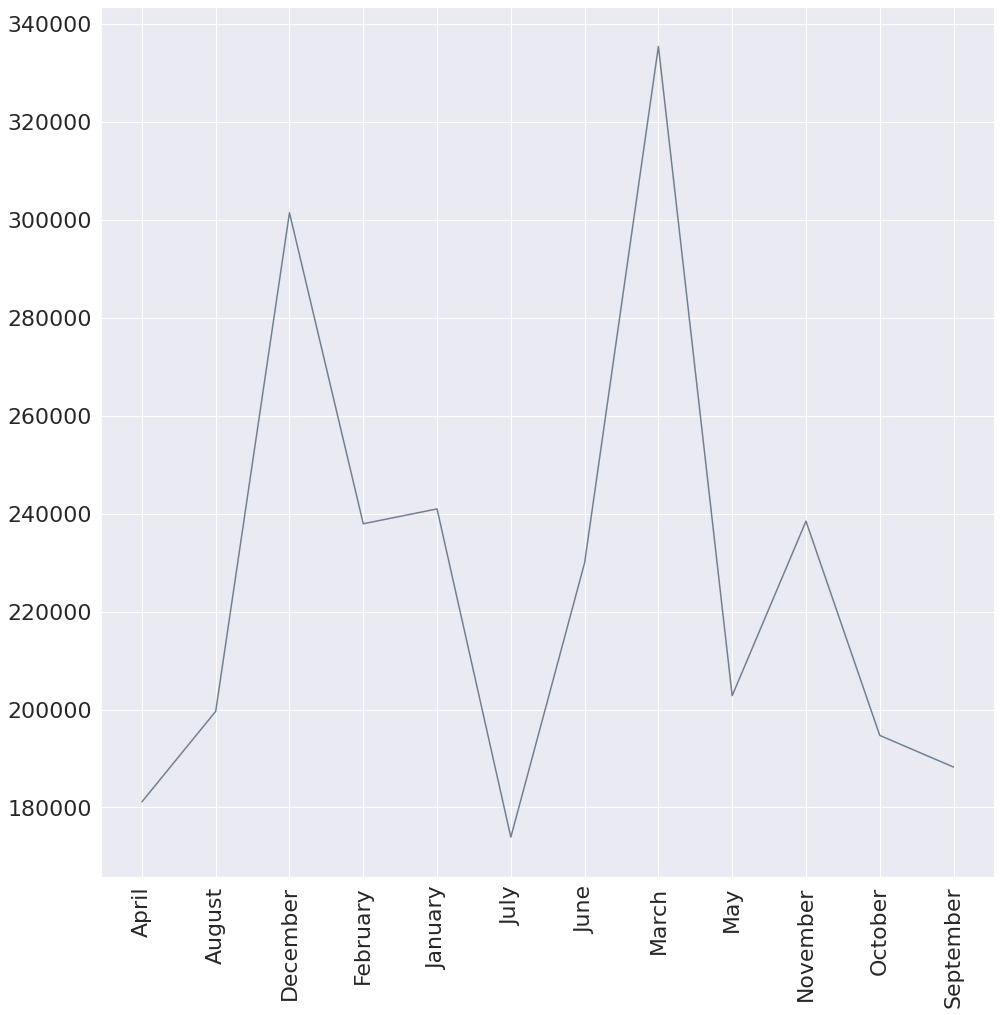

In [9]:
plt.figure(figsize=(16,16))
time_plot_data = time_data.groupby(time_data.index.month_name()).mean().sum(axis=1)
sns.lineplot(x=time_plot_data.index,y=time_plot_data.values, color = 'slategrey')#'firebrick')
plt.xticks(rotation='vertical')

In [10]:
time_data

,SKU-1,SKU-2,SKU-3,SKU-4,SKU-5,SKU-6,SKU-7,SKU-8,SKU-9,SKU-10,...,SKU-221,SKU-224,SKU-225,SKU-226,SKU-228,SKU-229,SKU-230,SKU-231,SKU-232,SKU-233
2018-04-01,27,88,6,162,171,4,1179,406,264,8,...,32,118,145,4,15,7,49,21,15,252
2018-05-01,13,28,6,184,402,4,435,652,244,8,...,24,139,65,36,15,7,25,13,13,105
2018-06-01,30,127,6,110,627,4,335,844,159,8,...,22,56,157,40,15,7,41,13,13,33
2018-07-01,14,130,6,172,615,52,719,541,204,8,...,36,61,225,20,15,7,13,21,11,39
2018-08-01,22,58,6,90,300,4,791,703,84,8,...,46,131,81,4,15,7,21,29,9,15
2018-09-01,8,10,6,40,417,12,783,634,129,8,...,52,211,325,84,15,7,53,21,11,33
2018-10-01,8,7,6,18,141,4,875,523,248,8,...,40,37,169,36,15,7,33,21,36,93
2018-11-01,8,7,6,26,42,4,935,688,166,8,...,34,115,489,148,15,7,21,29,15,69
2018-12-01,8,7,6,18,72,4,1407,1267,273,8,...,40,331,449,84,15,7,67,13,21,57
2019-01-01,8,13,6,66,33,4,699,463,186,8,...,56,218,497,4,15,7,21,13,15,213


In [11]:
# time_data_1.groupby(time_data.index.month_name()).mean().T.groupby(df.warehouse_id).mean().T.plot(kind='bar')

In [12]:
# time_data.groupby(time_data.index.month_name()).mean().T.groupby(df.warehouse_id).median().T.plot(kind='bar')

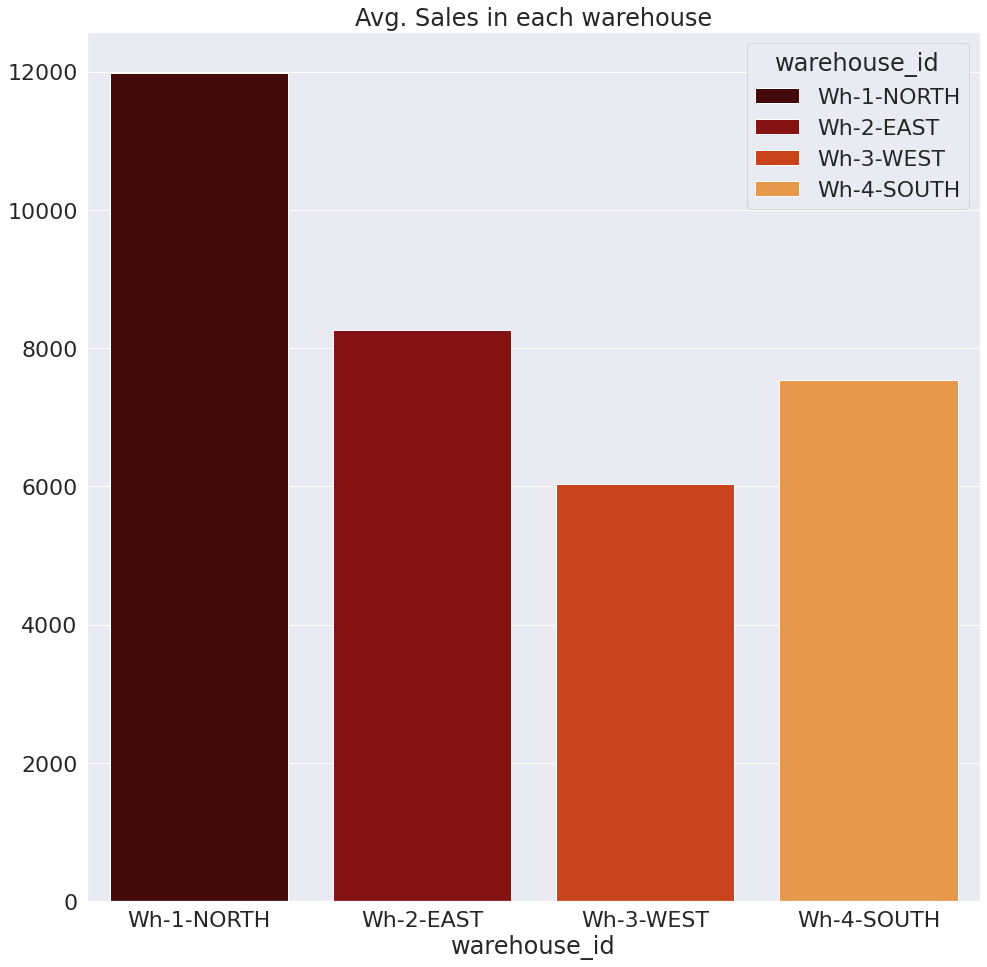

In [13]:
plt.figure(figsize=(16,16))
sales=df.iloc[:,3:].sum(axis=1)
sales_d = sales.groupby(df.warehouse_id).describe()['mean']
plt.title('Avg. Sales in each warehouse')
sns.barplot(x=sales_d.index,y=sales_d.values,hue=sales_d.index,palette=palette_name,dodge=False)



$y=x^3+5x^2-12$
***232323***

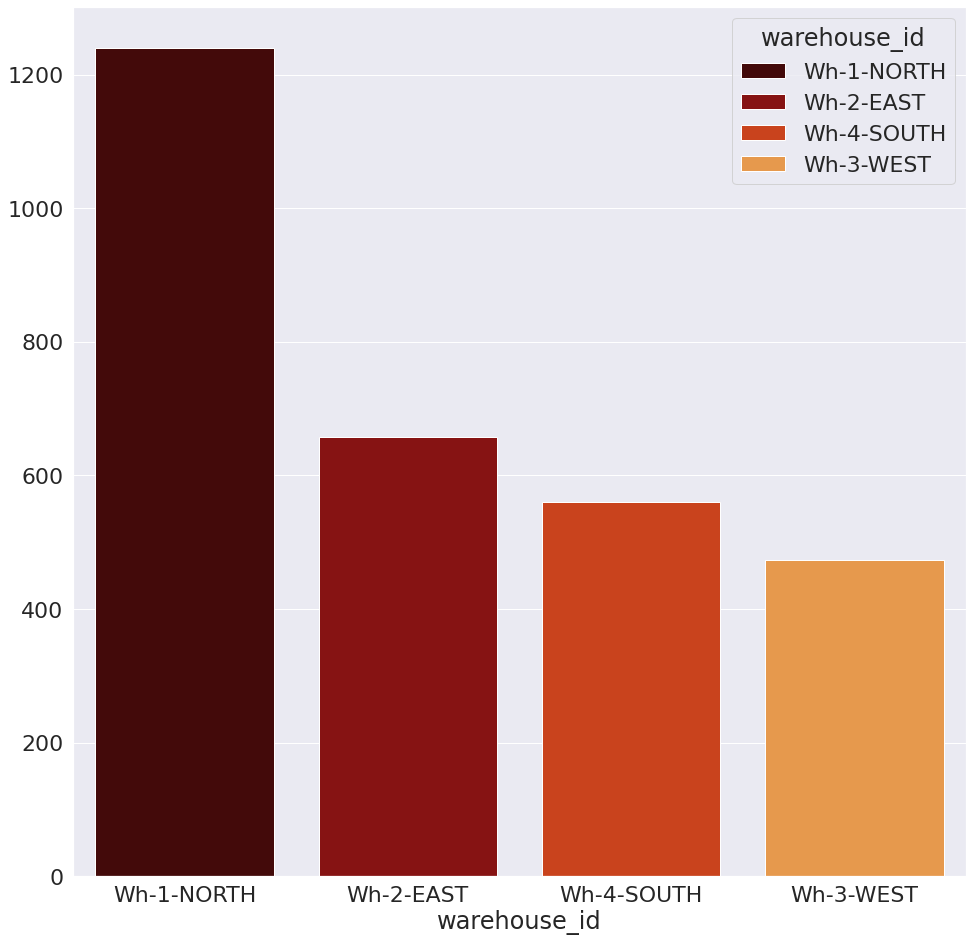

In [14]:
plt.figure(figsize=(16,16))
sales=df.iloc[:,24:27].sum(axis=1)
sales_d = sales.groupby(df.warehouse_id)
sales_d  = sales_d.describe()['mean'].sort_values(ascending=False)
sns.barplot(x=sales_d.index,y=sales_d.values,hue=sales_d.index,palette=palette_name,dodge=False)
# sales_d.sum()


In [15]:
def tt_split(data):
    x_val=train_df[train_df.mm_yy==train_df.mm_yy.max()]
    x_train=train_df[train_df.mm_yy!=train_df.mm_yy.max()]
    return x_train.drop(columns=["target","mm_yy"]),x_val.drop(columns=["target","mm_yy"]),x_train.target,x_val.target


def tt_model(model,x,y,isval=False):
    if not isval:
        model.fit(x,y)
    y_pred=model.predict(x)
    
    tag='Train'
    if isval:
        tag="Validation"
        
    print(f"{tag} Mape error: {mean_absolute_percentage_error(y,y_pred)}")
    return model, y_pred

def get_datapoints(ts,lags=13):
    banda_high_hai= [
        'Jun-2018',
         'Feb-2019',
         'Mar-2019',
         'Apr-2019',
         'Jun-2019',
         'Jul-2019',
         'Mar-2020',
         'Apr-2020',
         'May-2020',
         'Jun-2020',
         'Mar-2021',
         'Apr-2021',
    ]
    
    index=ts.index
    value=ts.values
    
    x=[]
    y=[]
    for i in range(lags,len(index)):
        features=[]
        
        expanding=value[:i]
        temp=np.array(value[i-lags:i])
        features.extend(temp[[0,1,2,7,11,12]].tolist())
        f1=0
        if index[i] in banda_high_hai:
            f1=1

        
        mean=temp[-4:].mean()
        std=temp[-4:].std()
        
        features.extend([index[i],f1,mean,std,expanding.mean(),expanding.std(),temp[[0,1,2,7,11,12]].mean()])
        
        x.append(features)
        y.append(value[i])
    return x,y
           

In [16]:
# c=0
df.drop(columns=['region'],inplace=True)

for warehouse_id in df.warehouse_id.unique():
    print(warehouse_id)
    XX=df[df.warehouse_id==warehouse_id].drop(columns=["sku_id","warehouse_id"])
    X=[]
    Y=[]
    x_test=[]

    for prod_ts in XX.iterrows():
        lags=13
        x,y=get_datapoints(prod_ts[1][:],lags)
        X.extend(x)
        Y.extend(y)
    
#     x_test.append(prod_ts[1][-1*lags-4:-4].tolist())
#     x_test[-1].append(prod_ts[1].index[-5])
#     x_test[-1].extend(prod_ts[1][-4:].tolist())
    train_df=pd.DataFrame(X)
    train_df.columns=[f"lag_{i}" for i in [13,12,11,6,2,1]]+["mm_yy","f1",'mean','std',"exanding_mean","exanding_std","mean2"]
    
    train_df.mm_yy=pd.to_datetime(train_df.mm_yy)
    train_df['month']=train_df.mm_yy.dt.month
    train_df['year']=train_df.mm_yy.dt.year
    # train_df['quarter']=train_df.mm_yy.dt.quarter
    train_df["target"]=Y
    print(sum(train_df.duplicated()))
    train_df.drop_duplicates(inplace=True)
    # train_df.drop(columns=['mm_yy'],inplace=True)

    
    # x_train,x_val,y_train,y_val=model_selection.train_test_split(train_df.drop(columns=["mm_yy"]),train_df.target,test_size=0.2,shuffle=True)
    x_train,x_val,y_train,y_val=tt_split(train_df)
    

    models_list=[
        ['rmf',ensemble.RandomForestRegressor(n_jobs=-1)],
        ['gbm',ensemble.GradientBoostingRegressor()],
        ['xgb',XGBRegressor()],
        ['lgbm',LGBMRegressor()],
        ['svm',svm.SVR()],
        ['catb',catboost.CatBoostRegressor(loss_function='MAPE',verbose=False)]
    #     ['knn',neighbors.KNeighborsRegressor()]
    ]

    for name, model in models_list:
        if name in ['lr','knn','svm']:
            minmax=preprocessing.MinMaxScaler()
            x_train_f,x_val_f=minmax.fit_transform(x_train),minmax.transform(x_val)
        else:
            x_train_f,x_val_f=x_train.copy(),x_val.copy()
        print(name)
        model,_=tt_model(model,x_train_f,y_train)
        model,_=tt_model(model,x_val_f,y_val,isval=True)
        print('-'*50)
#     break
    
    print("\n\n\n")

Wh-1-NORTH
742
rmf
Train Mape error: 2.288910859199708
Validation Mape error: 9.229485048022786
--------------------------------------------------
gbm
Train Mape error: 4.508356661516271
Validation Mape error: 6.539368749168568
--------------------------------------------------
xgb
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Mape error: 5.021712258438435
Validation Mape error: 6.491833883559728
--------------------------------------------------
lgbm
Train Mape error: 3.6532896515468636
Validation Mape error: 5.041576363390579
--------------------------------------------------
svm
Train Mape error: 3.895273535881055
Validation Mape error: 6.676119109439937
--------------------------------------------------
catb
Train Mape error: 0.6829664325218314
Validation Mape error: 0.8809248844181229
--------------------------------------------------




Wh-2-EAST
561
rmf
Train Mape error: 2.2315085308533593
Va

In [17]:
XX

,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,...,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020,Jan-2021,Feb-2021,Mar-2021,Apr-2021,May-2021
753,142,103,37,226,19,40,52,79,58,82,...,31,328,2374,34,19,37,76,73,112,19
754,170,106,22,58,38,18,22,22,58,70,...,42,70,10,38,22,18,50,74,30,50
755,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,23,15
756,196,58,120,54,58,224,204,86,190,108,...,116,4058,954,112,32,200,206,152,190,64
757,250,232,154,244,127,130,232,169,154,58,...,352,2089,730,178,130,154,364,817,727,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,7,7,7,7,7,7,7,7,7,7,...,591,167,455,215,135,239,295,7,7,135
1035,49,25,41,13,21,53,33,21,67,21,...,9,9,21,133,9,33,9,103,49,9
1036,21,13,13,21,29,21,21,29,13,13,...,13,13,13,13,13,21,13,13,13,13
1037,15,13,13,11,9,11,36,15,21,15,...,9,9,17,13,11,36,21,17,9,9


Text(0.5, 0, 'Relative Importance')

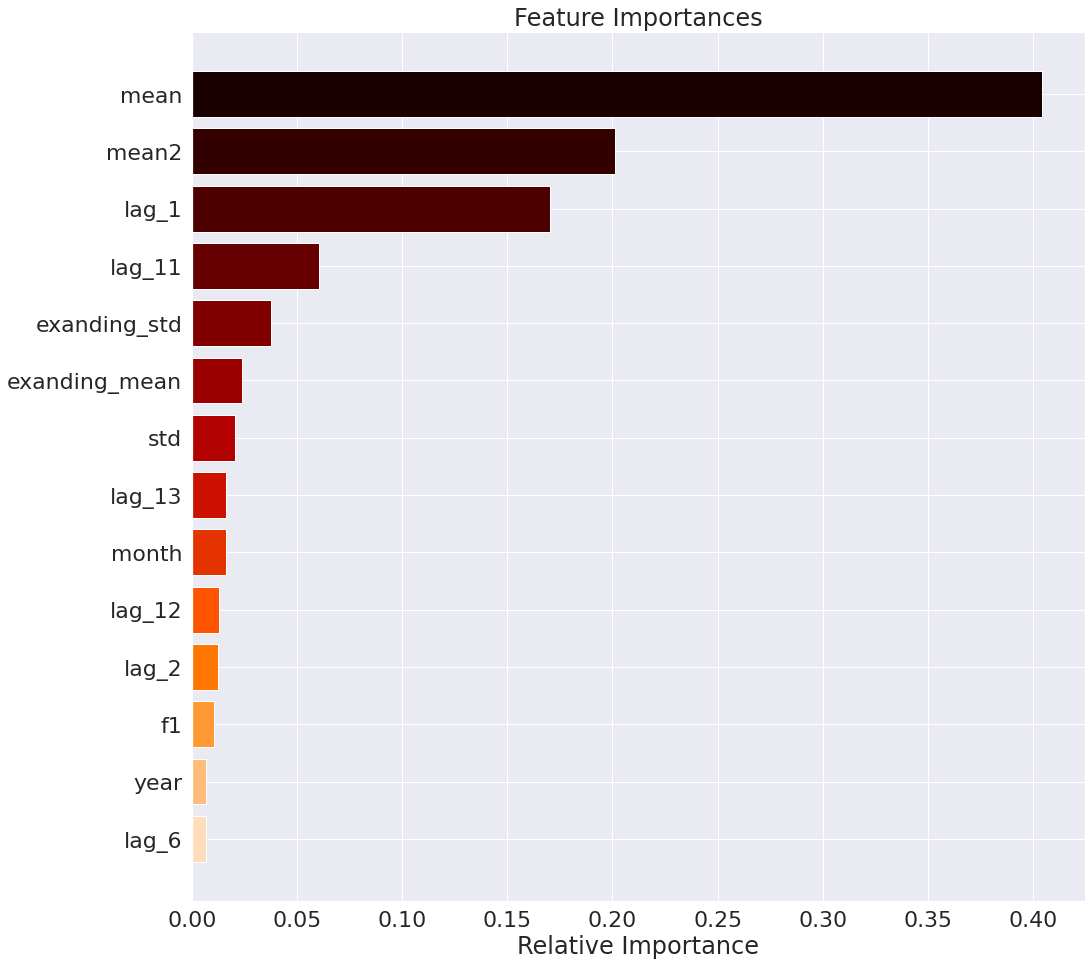

In [18]:
features=x_train.columns
importances = models_list[1][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,16))
plt.title('Feature Importances')
palette_0 = sns.color_palette(palette_name,n_colors=len(indices))
palette_0.reverse()
plt.barh(range(len(indices)), importances[indices], align='center',color=palette_0)
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [19]:
features

Index(['lag_13', 'lag_12', 'lag_11', 'lag_6', 'lag_2', 'lag_1', 'f1', 'mean',
       'std', 'exanding_mean', 'exanding_std', 'mean2', 'month', 'year'],
      dtype='object')

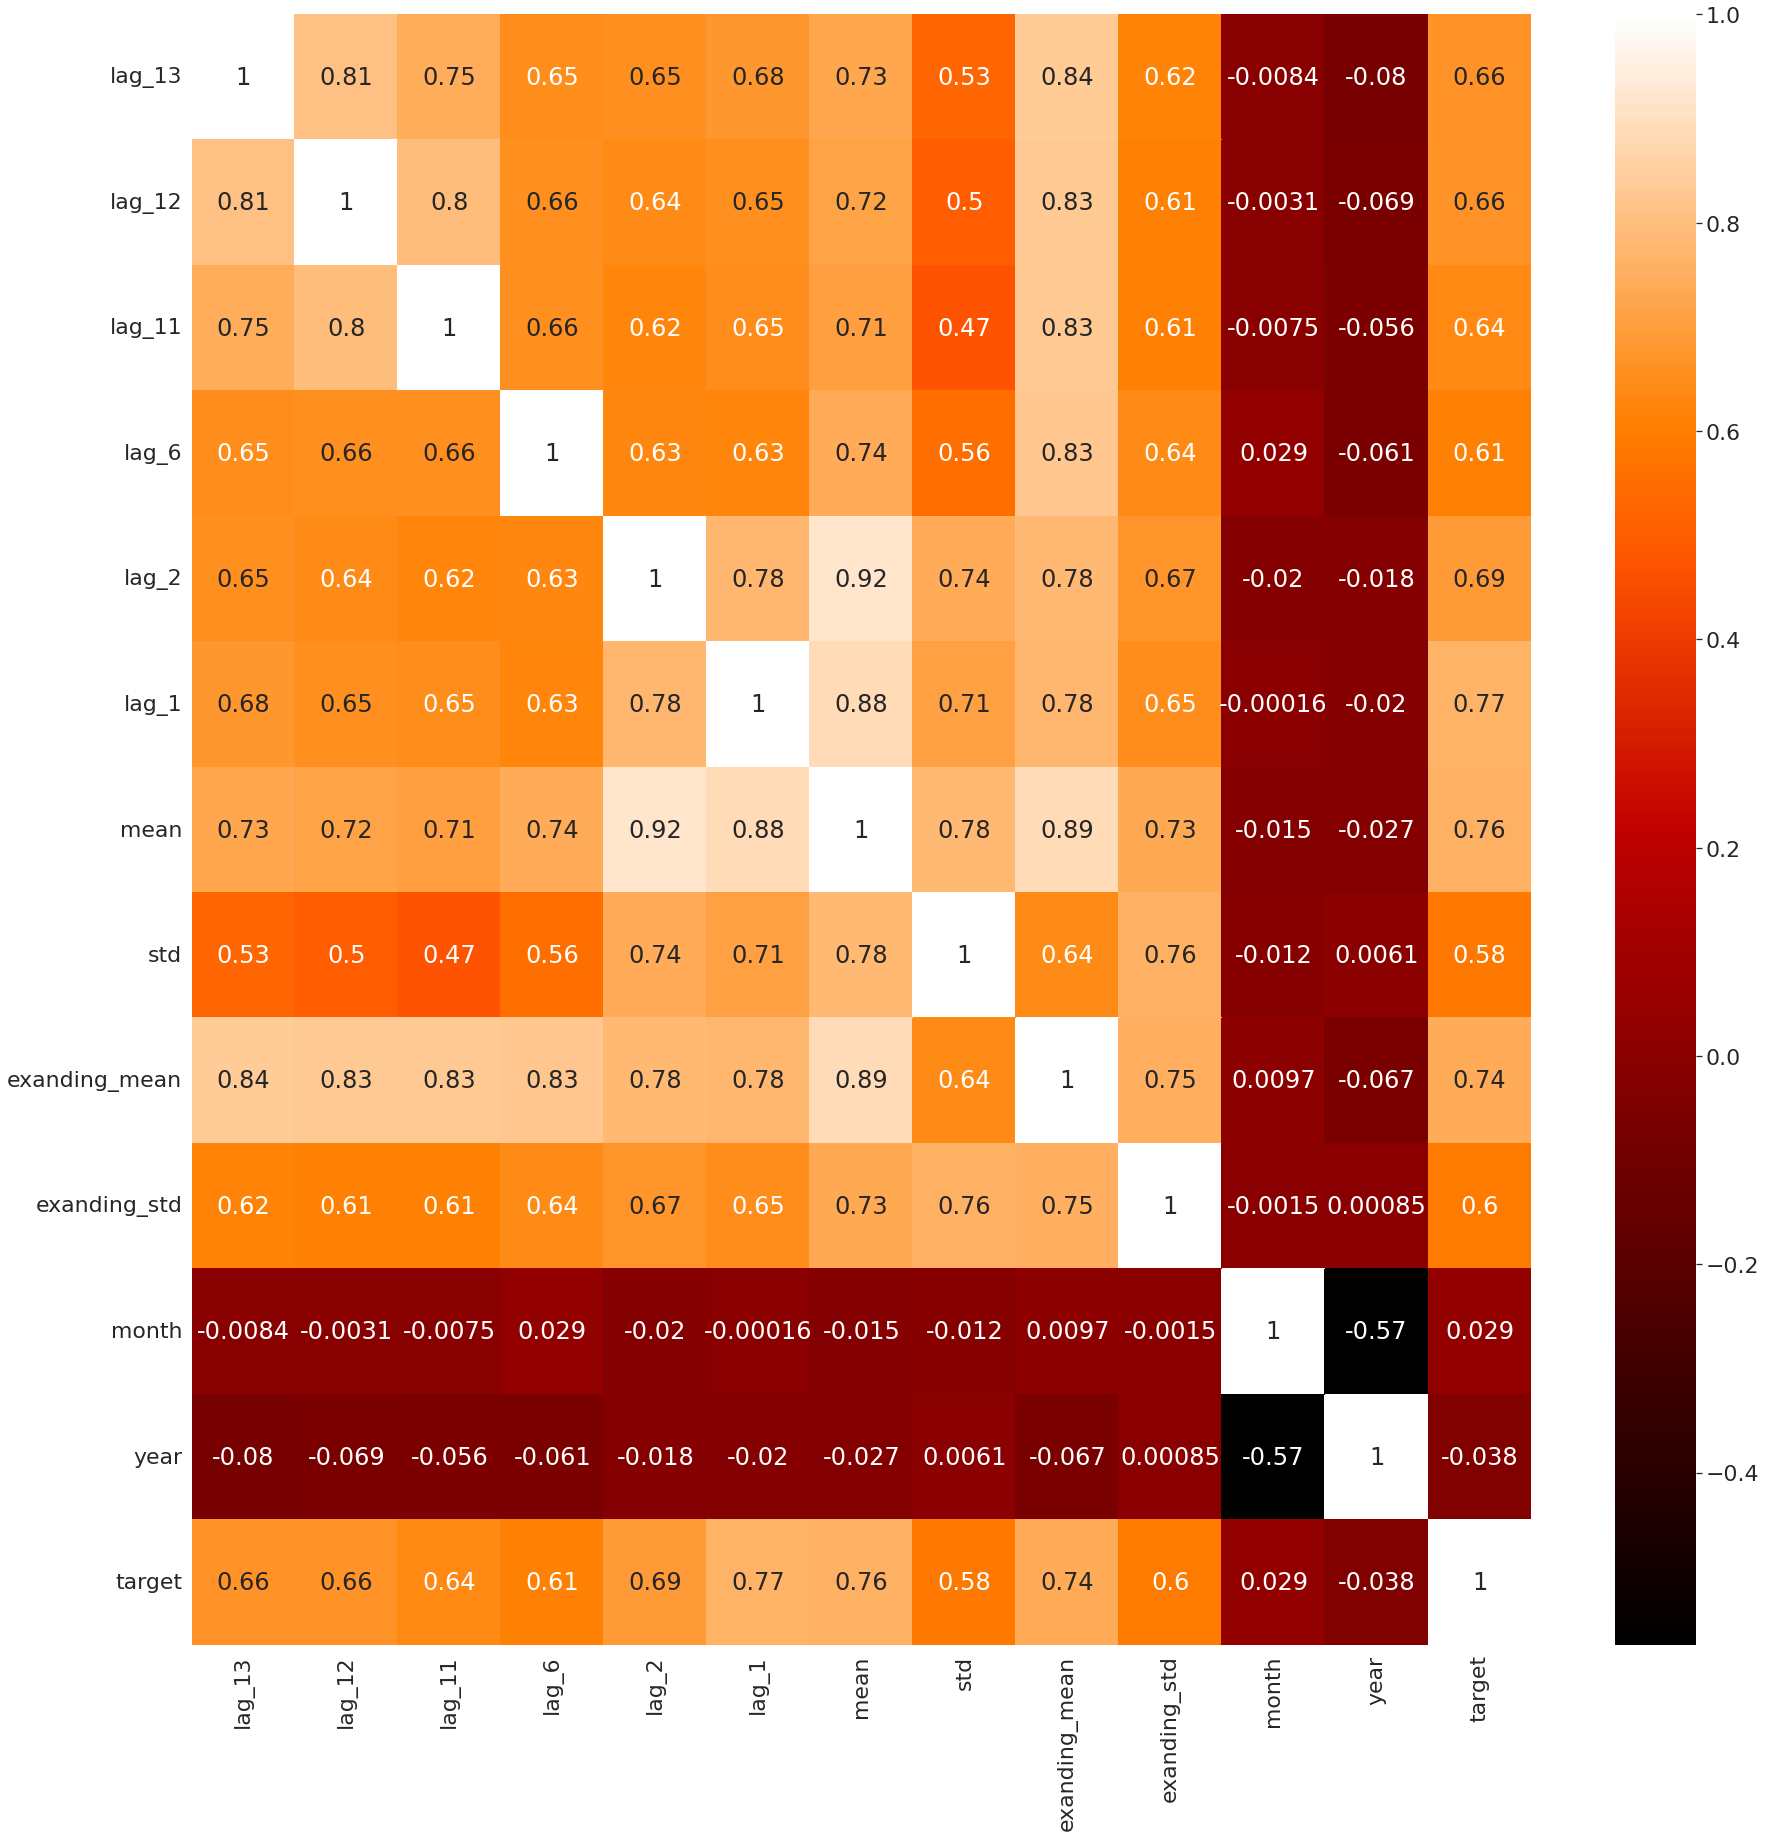

In [20]:
plt.figure(figsize=(30,30))
sns.heatmap(train_df[['lag_13', 'lag_12', 'lag_11', 'lag_6', 'lag_2', 'lag_1', 'mean', 'std',
       'exanding_mean', 'exanding_std', 'month', 'year', 'target']].corr(),annot=True,cmap = palette_name)

In [21]:
# from statsmodels.graphics.tsaplots import plot_pacf
# # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
# dd=df.sample(n=50)
# for i in range(50):
    
#     plot_pacf(dd.iloc[i,2:], lags=15)
#     plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

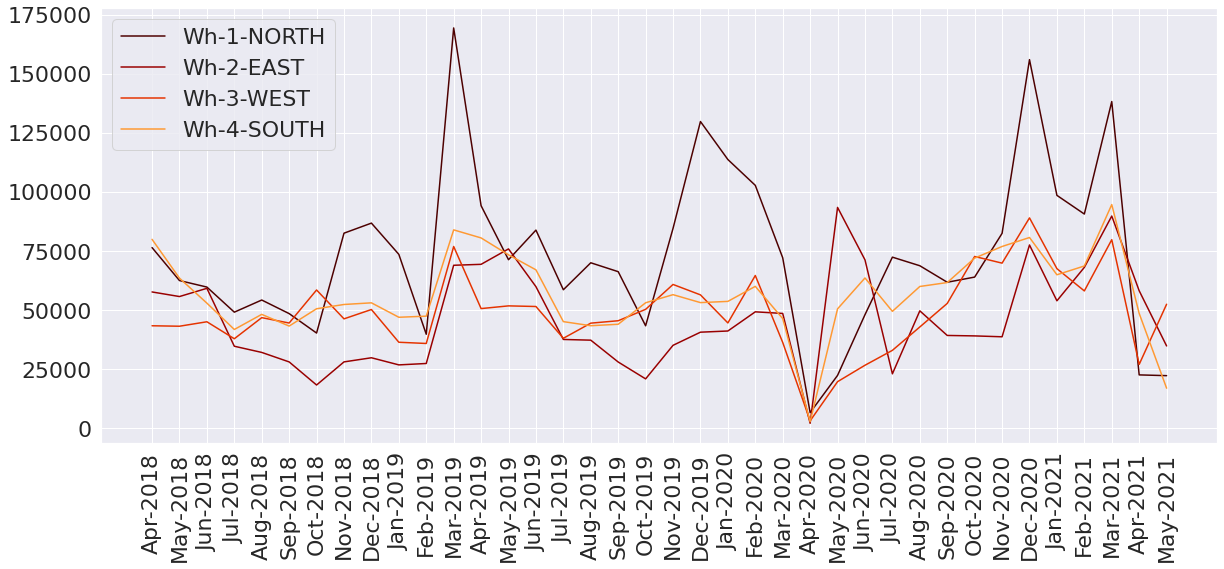

In [22]:
plt.figure(figsize=(20,8))
palette_1 = sns.color_palette(palette_name,len(df.warehouse_id.unique()))
for wid,palette_1i in zip(df.warehouse_id.unique(),palette_1):
#     print(wid)
    s=df[df.warehouse_id==wid].drop(columns=["sku_id","warehouse_id"]).sum(axis=0)
    sns.lineplot(s.index,s.values.astype(int),color=palette_1i)
    
#     plt.show()
_=plt.xticks(rotation="90")
plt.legend(df.warehouse_id.unique())
plt.show()

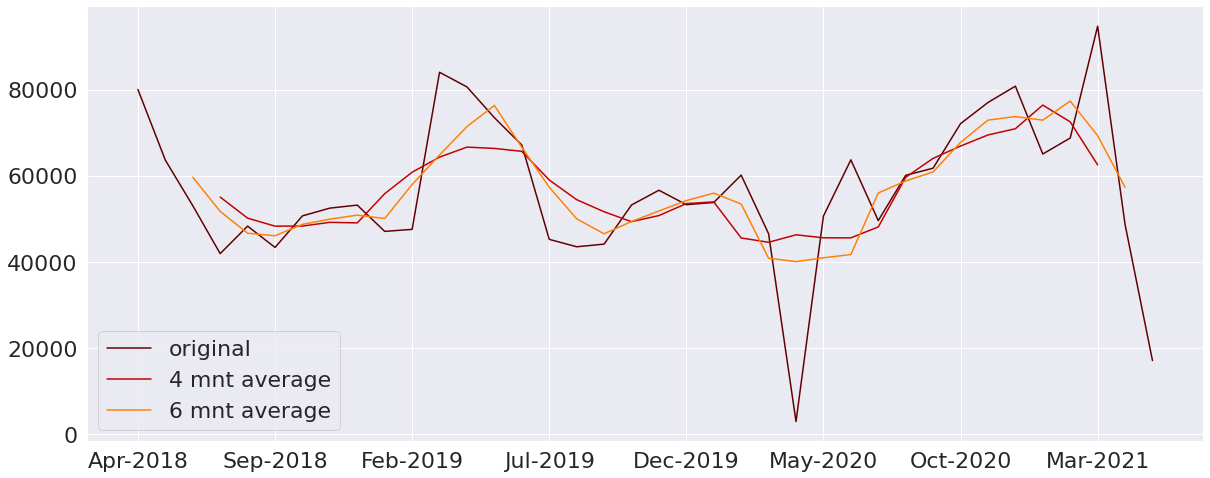

In [23]:
plt.figure(figsize=(20,8))
df_6m_mean = s.rolling(6, center=True).mean()
df_4m_mean = s.rolling(4, center=True).mean()
df_4m_std = s.rolling(4, center=True).std()
df_6m_std = s.rolling(6, center=True).std()
palette_2 = sns.color_palette(palette_name,3)
s.plot(color = palette_2[0])
df_6m_mean.plot(color = palette_2[1])
df_4m_mean.plot(color = palette_2[2])
plt.legend(['original','4 mnt average','6 mnt average'])


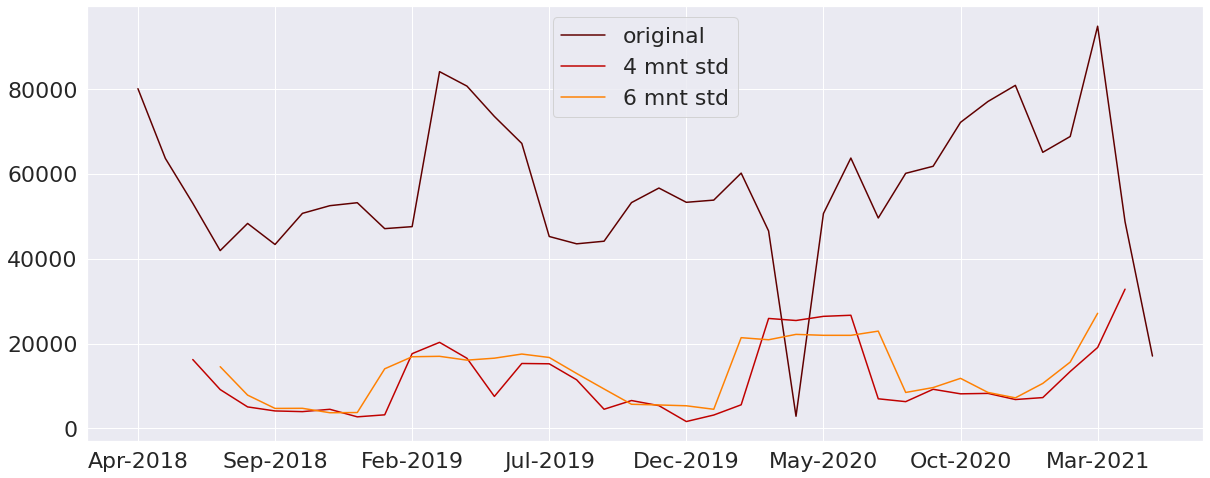

In [24]:
plt.figure(figsize=(20,8))
s.plot(color = palette_2[0])
df_4m_std.plot(color = palette_2[1])
df_6m_std.plot(color = palette_2[2])
plt.legend(['original','4 mnt std','6 mnt std'])


([<matplotlib.axis.YTick at 0x7f8ce0515850>,
 <a list of 9 Text major ticklabel objects>)

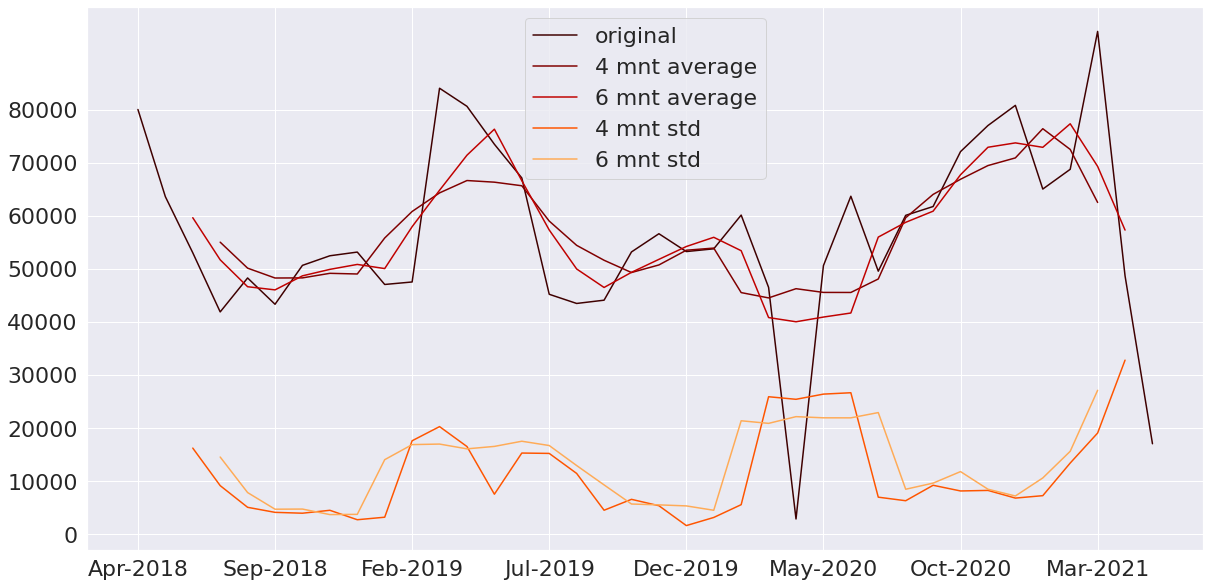

In [25]:
plt.figure(figsize=(20,10))
palette_2 = sns.color_palette(palette_name,5)
s.plot(color = palette_2[0])
df_6m_mean.plot(color = palette_2[1])
df_4m_mean.plot(color = palette_2[2])
df_4m_std.plot(color = palette_2[3])
df_6m_std.plot(color = palette_2[4])
plt.legend(['original','4 mnt average','6 mnt average','4 mnt std','6 mnt std'])
plt.yticks(np.arange(0, 90000, step=10000))

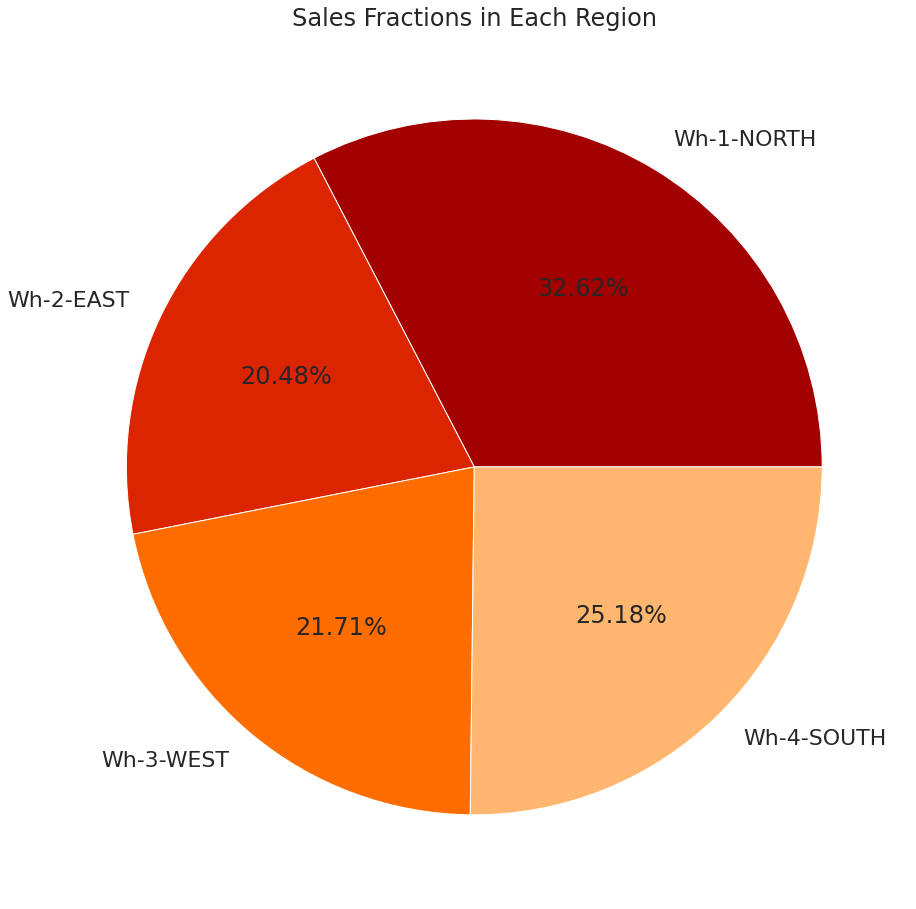

In [26]:
plt.figure(figsize=(16,16))
sales_total = df.groupby('warehouse_id').sum().T.sum()
plt.pie(sales_total.values,labels=sales_total.index,colors=sns.color_palette(palette_name,6)[2:],autopct='%.2f%%')
plt.title('Sales Fractions in Each Region')
plt.show()

In [27]:
%pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# time_data_1 = df.copy()
# time_data_1.drop(columns=['sku_id'],inplace=True)

In [29]:
# time_data_1.index = time_data_1['warehouse_id']
# time_data_1.drop(columns=['warehouse_id'],inplace = True)
# time_data_1

In [30]:
# sns.barplot(data = time_data_1.groupby(time_data_1.index).mean(),)

In [31]:
# plt.figure(figsize=(20,8))
# time_data_1.groupby(time_data_1.T.index).mean().T.groupby(df.warehouse_id).mean().T.plot(kind='bar')

In [32]:

# time_data_1.groupby(time_data.index.month_name()) #.mean().T.groupby(df.warehouse_id).mean().T.plot(kind='bar')

In [33]:
time_data_1=df.T.iloc[0:]
time_data_1=time_data_1.drop(['sku_id'],axis=0)
time_data_1.columns=time_data_1.iloc[0,:].tolist()
time_data_1=time_data_1.iloc[1:,:].astype(int)
time_data_1.index=pd.to_datetime(time_data_1.index)
time_data_1

,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,Wh-1-NORTH,...,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH,Wh-4-SOUTH
2018-04-01,27,88,6,162,171,4,1179,406,264,8,...,32,118,145,4,15,7,49,21,15,252
2018-05-01,13,28,6,184,402,4,435,652,244,8,...,24,139,65,36,15,7,25,13,13,105
2018-06-01,30,127,6,110,627,4,335,844,159,8,...,22,56,157,40,15,7,41,13,13,33
2018-07-01,14,130,6,172,615,52,719,541,204,8,...,36,61,225,20,15,7,13,21,11,39
2018-08-01,22,58,6,90,300,4,791,703,84,8,...,46,131,81,4,15,7,21,29,9,15
2018-09-01,8,10,6,40,417,12,783,634,129,8,...,52,211,325,84,15,7,53,21,11,33
2018-10-01,8,7,6,18,141,4,875,523,248,8,...,40,37,169,36,15,7,33,21,36,93
2018-11-01,8,7,6,26,42,4,935,688,166,8,...,34,115,489,148,15,7,21,29,15,69
2018-12-01,8,7,6,18,72,4,1407,1267,273,8,...,40,331,449,84,15,7,67,13,21,57
2019-01-01,8,13,6,66,33,4,699,463,186,8,...,56,218,497,4,15,7,21,13,15,213


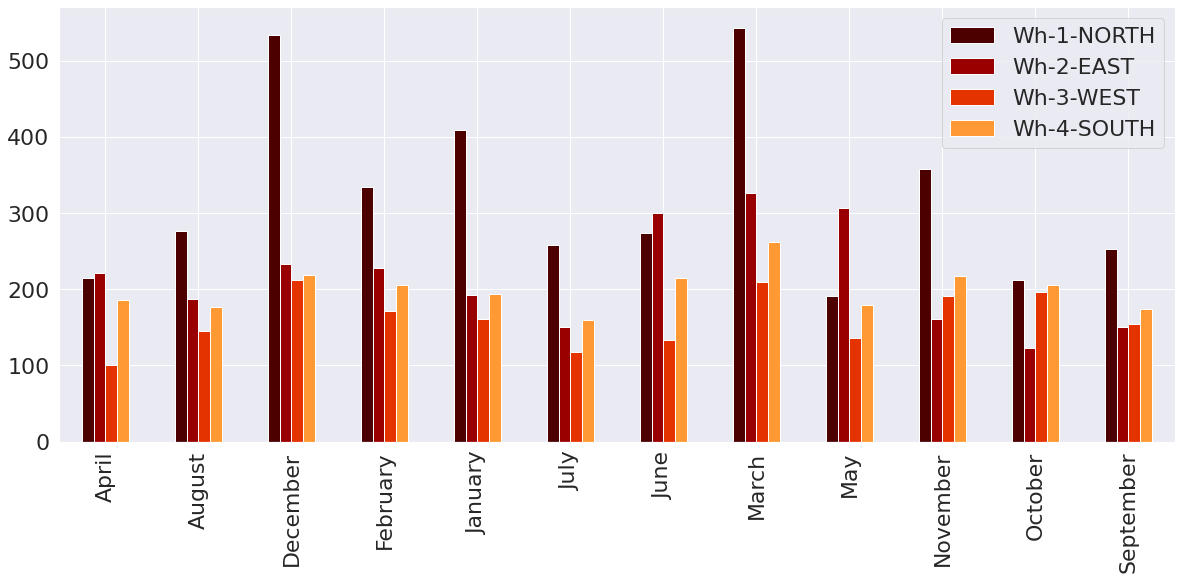

In [34]:
palette_3 = sns.color_palette(palette_name,4)
grouped_sales_1 = time_data_1.groupby(time_data_1.index.month_name()).mean().T.groupby(time_data_1.columns).mean().T.plot(kind='bar',figsize=(20,8),color = palette_3)
# sns.barplot(grouped_sales_1)
# sns.barplot(data= grouped_sales_1, x = grouped_sales_1.index, y= 'sales' ,hue = grouped_sales_1.index, )

In [35]:
grouped_sales_1

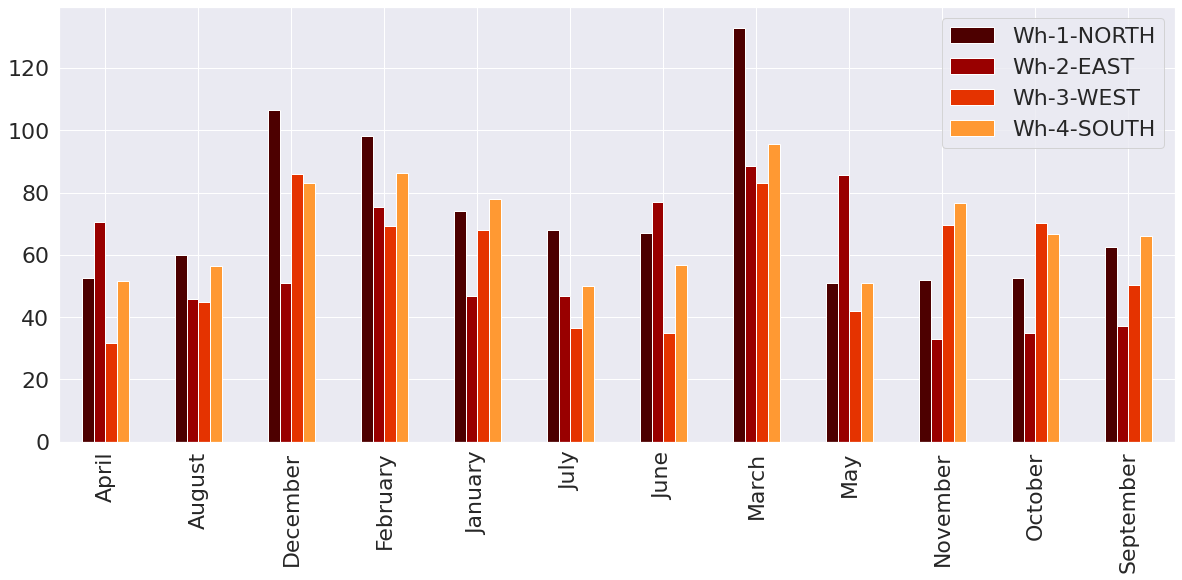

In [36]:
grouped_sales_1 = time_data_1.groupby(time_data_1.index.month_name()).mean().T.groupby(time_data_1.columns).median().T.plot(kind='bar',figsize=(20,8),color = palette_3)

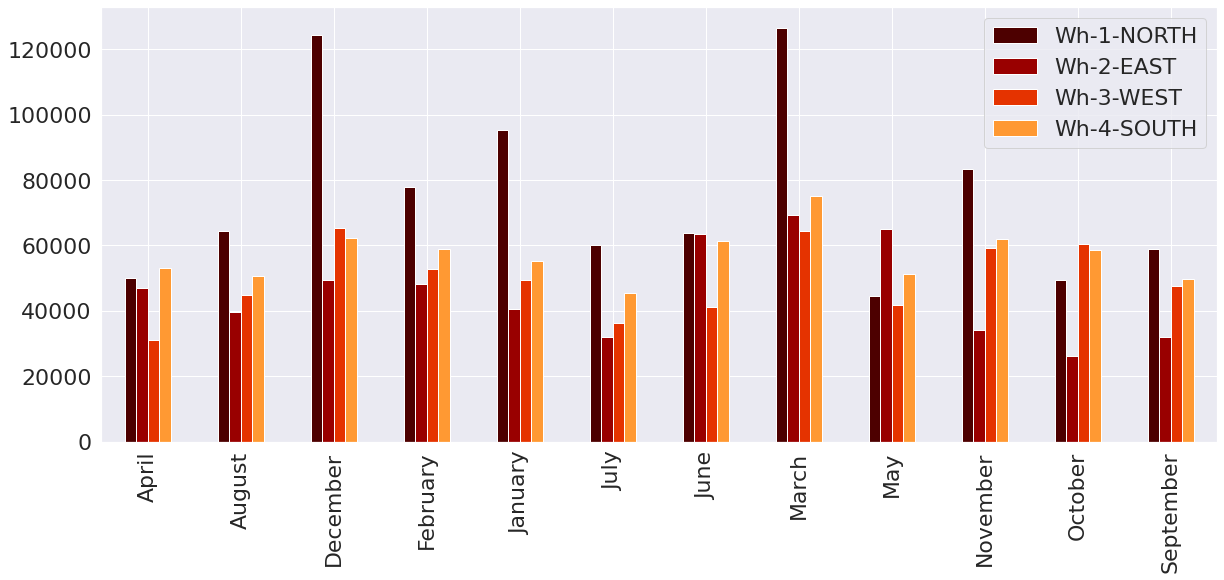

In [37]:
grouped_sales_1 = time_data_1.groupby(time_data_1.index.month_name()).mean().T.groupby(time_data_1.columns).sum().T.plot(kind='bar',figsize=(20,8),color = palette_3)